# Comprehensive Tutorial on Building a RAG Application Using LangChain

## Introduction

Today’s large language models have access to an ever-growing amount of information. However, there remains a vast trove of private data that these models do not tap into. This is why one of the most popular applications of LLMs in enterprise settings is retrieval-augmented generation—RAG for short. At Vizly, our AI-powered data analysis platform, we have gained valuable insights into building effective RAG systems. In this tutorial, we will share some of our learnings and show you how to create your own RAG system. 

You will learn how to use LangChain, the massively popular framework for building RAG systems, to build a simple RAG system. By the end of the tutorial, we will have a chatbot (with a Streamlit interface and all) that will RAG its way through some private data to give answers to questions.

## What is RAG?

To clarify what RAG is, let’s consider a simple example.

A first-year college student, Chandler, is considering skipping a few classes but wants to ensure he isn’t violating the university attendance policy. Like with anything these days, he asks ChatGPT the question.

Of course, ChatGPT can’t answer it. The chatbot isn’t dumb — it just doesn’t have access to Chandler’s university documents. So, Chandler finds the policy document himself and discovers that it is a long, technical read he doesn’t want to wade through.

Instead, he gives the entire document to ChatGPT and asks the question again. This time, he gets his answer.
This is an individual case of retrieval-augmented generation. The language model’s answer (generation) is augmented (enriched) by context retrieved from a source not part of its original training.

A scalable version of a RAG system would be able to answer any student question by searching university documents itself, finding the relevant ones, and retrieving chunks of text that most likely contain the answer.
Generally speaking, in a RAG system, you retrieve information from a private data source and feed it to a language model, enabling the model to give a contextually relevant answer. 

## Components of a RAG Application

Such a system, despite sounding straightforward, would have a lot of moving components. Before building one ourselves, we need to review what they are and how they play together.

### Documents

The first component is a document or a collection of documents. Based on the type of RAG system we are building, the documents can be text files, PDFs, web pages (RAG over unstructured data) or graph, SQL, NoSQL databases (RAG over structured data). They are used to ingest various types of data into the system.

### Document loaders

LangChain implements hundreds of classes called _document loaders_ to read data from various document sources such as PDFs, Slack, Notion, Google Drive, and so on. 

Each DocumentLoader class is unique but they all share the same `.load()` method. For example, here is how you can load a PDF document and a webpage in LangChain:

In [6]:
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader  # pip install langchain-community

pdf_loader = PyPDFLoader("framework_docs.pdf")
web_loader = WebBaseLoader(
    "https://python.langchain.com/v0.2/docs/concepts/#document-loaders"
)

pdf_docs = pdf_loader.load()
web_docs = web_loader.load()

The PyPDFLoader class handles PDF files using the PyPDF2 package under the hood, while the `WebBaseLoader` scrapes the given webpage contents. 

`pdf_docs` contains four document objects, one for each page:

In [12]:
len(pdf_docs)

4

While `web_docs` contain only one:

In [18]:
print(web_docs[0].page_content[125:300].strip())

You can view the v0.1 docs here.IntegrationsAPI referenceLatestLegacyMorePeopleContributingCookbooks3rd party tutorialsYouTubearXivv0.2v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangCh


These document objects are later given to embedding models to understand the semantic meaning behind their text. 

For specifics on other types of document loaders, LangChain offers a [dedicated how-to page](https://python.langchain.com/v0.2/docs/how_to/#document-loaders).

### Text splitters

Once you have loaded your documents, it is crucial to break them down into smaller and more manageable chunks of text. Here are the main reasons:

1. Many embedding models (more on them later) have a maximum token limit.
2. Retrieval is more accurate when you have smaller chunks.
3. The language model is fed the exact context.

LangChain offers many types of text splitters under its `langchain_text_splitters` package and they differ based on document type. 

Here is how to use `RecursiveCharacterTextSplitter` to split plain text based on a list of separators and chunk size:

In [ ]:
!pip install langchain_text_splitters

In [20]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Example text
text = """
RAG systems combine the power of large language models with external knowledge sources.
This allows them to provide up-to-date and context-specific information.
The process involves several steps including document loading, text splitting, and embedding.
"""

# Create a text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=50,
    chunk_overlap=10,
    length_function=len,
    separators=["\n\n", "\n", " ", ""],
)

# Split the text
chunks = text_splitter.split_text(text)

# Print the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

Chunk 1: RAG systems combine the power of large language
Chunk 2: language models with external knowledge sources.
Chunk 3: This allows them to provide up-to-date and
Chunk 4: and context-specific information.
Chunk 5: The process involves several steps including
Chunk 6: including document loading, text splitting, and
Chunk 7: and embedding.


This splitter is versatile and works well for many uses cases. It creates each chunk with a character count as close to `chunk_size` as possible. It can recursively switch between which separators to split at to keep the character count.

In the above example, our splitter tries to split on newlines first, then single spaces, and finally between any characters to reach the desired chunk size.

There are many other splitters inside `langchain_text_splitters` package. Here are some:
- HTMLSectionSplitter
- PythonCodeTexSplitter
- RecursiveJsonSplitter

and so on. Some of the splitters create semantically meaningful chunks by using a transformer model under the hood. 

The right text splitter has a significant impact on the performance of a RAG system.

For specifics on how to use text splitters, see the relevant [how-to guides here](https://python.langchain.com/v0.2/docs/how_to/#text-splitters).

### Embedding models

Once documents are split into text, they need to be encoded into their numeric representation, which is a requirement for all computation models working with text data.

In the context of RAG, this encoding is called _embedding_ and done by _embedding models_. They create a vector representation of a piece of text that captures their semantic meaning. 

By presenting text in this way, you can do mathematical operations on them like searching our document database for text most similar in meaning or find an answer to a user query.

LangChain supports all major embedding model providers such as OpenAI, Cohere, HuggingFace, and so on. They are implemented as `Embedding` classes and provide two methods: one for embedding documents and one for embedding queries (prompts). 

Here is an example code that embeds the chunks of text we created in the previous section using OpenAI:

In [22]:
from langchain_openai import OpenAIEmbeddings

# Initialize the OpenAI embeddings
embeddings = OpenAIEmbeddings()

# Embed the chunks
embedded_chunks = embeddings.embed_documents(chunks)

# Print the first embedded chunk to see its structure
print(f"Shape of the first embedded chunk: {len(embedded_chunks[0])}")
print(f"First few values of the first embedded chunk: {embedded_chunks[0][:5]}")

Shape of the first embedded chunk: 1536
First few values of the first embedded chunk: [-0.020282309502363205, -0.0015041005099192262, 0.004193042870610952, 0.00229285703971982, 0.007068077567964792]


The output above shows that the embedding model is creating a 1536-dimensional vector for all chunks in our documents. 

To embed a single query, you can use the `embed_query()` method:

In [23]:
query = "What is RAG?"
query_embedding = embeddings.embed_query(query)
print(f"Shape of the query embedding: {len(query_embedding)}")
print(f"First few values of the query embedding: {query_embedding[:5]}")

Shape of the query embedding: 1536
First few values of the query embedding: [-0.012426204979419708, -0.016619959846138954, 0.007880032062530518, -0.0170428603887558, 0.011404196731746197]


### Vector stores

In large-scale RAG applications where you may have gigabytes of documents, you will end up with gazillion text chunks and thus, vectors. There isn't any use to them if you can't store them reliably.

This is why _vector stores or databases_ are all the rage now. Apart from storing your embeddings, vector databases take care of performing vector search for you. These databases are optimized to quickly find the most similar vectors when given a query vector, which is essential for retrieving relevant information in RAG systems.

Here is a snippet of code that embeds the contents of a web page and stores the vectors into a Chroma vector database (Chroma is an open-source vector database solution that runs entirely on your machine):

In [ ]:
!pip install chromadb langchain_chroma

In [33]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the web page
loader = WebBaseLoader("https://python.langchain.com/v0.2/docs/tutorials/rag/")
docs = loader.load()

# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(docs)

First, we load the page with `WebBaseLoader` and create our chunks. Then, we can directly pass the chunks to the `from_documents` method of `Chrome` along with our embedding model of choice:

In [29]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

db = Chroma.from_documents(chunks, OpenAIEmbeddings())

All vector database objects in LangChain expose a `similarity_search` method that accepts a query string:

In [38]:
query = "What is indexing in the context of RAG?"
docs = db.similarity_search(query)

print(docs[1].page_content)

data. If you are interested for RAG over structured data, check out our tutorial on doing question/answering over SQL data.Concepts​A typical RAG application has two main components:Indexing: a pipeline for ingesting data from a source and indexing it. This usually happens offline.Retrieval and generation: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.The most common full sequence from raw data to answer looks like:Indexing​Load: First we need to load our data. This is done with Document Loaders.Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.Store: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.Retrieval and


The result of `similarity_search` is a list of documents that most likely contain the information we are asking in the query. 

For specifics on how to use vector stores, see the relevant [how-to guides here](https://python.langchain.com/v0.2/docs/how_to/#vector-stores).

### Retrievers

Although all vector stores support retrieval in the form of similarity search, LangChain implements a dedicated `Retriever` interface that return documents given an unstructured query. A retriever only needs to return or retrieve documents, not store them.

Here is how you can convert any vector store to a retriever in LangChain:

In [40]:
# Convert the vector store to a retriever
chroma_retriever = db.as_retriever()

docs = chroma_retriever.invoke("What is indexing in the context of RAG?")

len(docs)

4

It is possible to limit the number of relevant documents to top _k_ using `search_kwargs`:

In [41]:
chroma_retriever = db.as_retriever(search_kwargs={"k": 1})

docs = chroma_retriever.invoke("What is indexing in the context of RAG?")

len(docs)

1

You can pass other search-related parameters to `search_kwargs`. Learn more about using retrievers from [specific how-to guides](https://python.langchain.com/v0.2/docs/how_to/#retrievers).

## Step-by-Step Workflow to Building a RAG App in LangChain

Now that we have covered the key components of a RAG system, we will build one ourselves. I will walk you through a step-by-step implementation of a RAG chatbot designed specifically for code documentation and tutorials. You will find it particularly useful when you need AI coding assistance for new frameworks or new features of existing frameworks that aren't yet part of the knowledge base of today's LLMs. 

### 0. Creating the project structure

First, populate your working directory with the following project structure:

```bash
rag-chatbot/
├── .gitignore
├── requirements.txt
├── README.md
├── app.py
├── src/
│   ├── __init__.py
│   ├── document_processor.py
│   └── rag_chain.py
└── .streamlit/
    └── config.toml
```

Here are the commands:

```bash
$ touch .gitignore requirements.txt README.md app.py
$ mkdir src .streamlit
$ touch src/{.env,__init__.py,document_processor.py,rag_chain.py}
$ touch .streamlit/{.env,config.toml}
```

### 1. Setting up the environment

In this step, you first create a new Conda environment and activate it:

```bash
$ conda create -n rag_tutorial python=3.9 -y
$ conda activate rag_tutorial
```

Next, open the `requirements.txt` file and paste the following dependencies:

```python
langchain==0.2.14
langchain_community==0.2.12
langchain_core==0.2.35
langchain_openai==0.1.22
python-dotenv==1.0.1
streamlit==1.37.1
faiss-cpu
pypdf
```

and install them:

```bash
$ pip install -r requirements.txt
```

Also, create a `.gitignore` file to hide files from git indexing:

```
# .gitignore
venv/
__pycache__/
.env
*.pdf
*.png
*.jpg
*.jpeg
*.gif
*.svg
```

### 2. Setting up document loaders

Next, open the `src/document_processor.py` file and paste the coming snippets of code.

The necessary imports:

```python
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import Language
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.parsers.pdf import (
    extract_from_images_with_rapidocr,
)
from langchain.schema import Document
import logging
```

Explanation of the imports:
- `RecursiveCharacterTextSplitter`: Splits text into smaller chunks recursively.
- `Language`: Enum for specifying programming languages in text splitting.
- `PyPDFLoader`: Loads and extracts text from PDF files.
- `extract_from_images_with_rapidocr`: OCR function for extracting text from images.
- `Document`: Represents a document with content and metadata.
- `logging`: Provides logging functionality for debugging and information.


Then, a function for processing PDFs:

```python
def process_pdf(source):
    loader = PyPDFLoader(source)
    documents = loader.load()

    # Filter out scanned pages
    unscanned_documents = [doc for doc in documents if doc.page_content.strip() != ""]

    scanned_pages = len(documents) - len(unscanned_documents)
    if scanned_pages > 0:
        logging.info(f"Omitted {scanned_pages} scanned page(s) from the PDF.")

    if not unscanned_documents:
        raise ValueError(
            "All pages in the PDF appear to be scanned. Please use a PDF with text content."
        )

    return split_documents(unscanned_documents)
```


Here is how it works:

1. It loads the PDF using `PyPDFLoader`.
2. It filters out scanned pages by removing documents with empty content.
3. It logs the number of scanned pages omitted, if any.
4. If all pages are scanned (i.e., no text content), it raises a ValueError.
5. Finally, it splits the remaining unscanned documents into smaller chunks using the split_documents function.

The function handles cases where a PDF might contain a mix of text and scanned pages, ensuring that only text-based pages are processed further. This is crucial for text analysis tasks where scanned pages without OCR would be unusable. We will define the `split_documents` function later.

Next, we write a function for retrieving information from images (screenshots of code snippets and/or webpages):

```python
def process_image(source):
    # Extract text from image using OCR
    with open(source, "rb") as image_file:
        image_bytes = image_file.read()

    extracted_text = extract_from_images_with_rapidocr([image_bytes])
    documents = [Document(page_content=extracted_text, metadata={"source": source})]
    return split_documents(documents)
```


This function processes an image file by extracting text using OCR (Optical Character Recognition). It reads the image file, converts it to bytes, and then uses the RapidOCR library to extract text from the image. The extracted text is then wrapped in a Document object with metadata containing the source file path. Finally, the function splits the document into smaller chunks using the `split_documents` function, which we define next:



```python
def split_documents(documents):
    # Split documents into smaller chunks for processing
    text_splitter = RecursiveCharacterTextSplitter.from_language(
        language=Language.PYTHON, chunk_size=1000, chunk_overlap=200
    )
    return text_splitter.split_documents(documents)
```

The function uses the `RecursiveCharacterTextSplitter` class with Python's syntax to split text into chunks of 1000 characters and 200 character overlap.

Our final function combines the PDF and image parser functions into one:

```python
def process_document(source):
    # Determine file type and process accordingly
    if source.lower().endswith(".pdf"):
        return process_pdf(source)
    elif source.lower().endswith((".png", ".jpg", ".jpeg")):
        return process_image(source)
    else:
        raise ValueError(f"Unsupported file type: {source}")
```

This final function will be used by the Streamlit UI down the line to create, embed and store chunks from provided documents and pass them down to the RAG component of our system. 

### 3. Setting up RAG

Now, open the `src/rag_chain.py` file and paste the coming snippets of code.

First, import necessary modules:

```python
import os
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Load the API key from env variables
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
```

Here is an explanation of the imports:

• `os`: Operating system interactions
• `dotenv`: Load environment variables
• `langchain` components:
  - `PromptTemplate`: Custom prompt creation
  - `FAISS`: A lightweight vector store for documents
  - `StrOutputParser`: Converting LLM message objects into string outputs
  - `RunnablePassthrough`: Create composable chains
  - `ChatOpenAI`, `OpenAIEmbeddings`: OpenAI model interactions


Next, we create our prompt for the RAG system:

```python
RAG_PROMPT_TEMPLATE = """
You are a helpful coding assistant that can answer questions about the provided context. The context is usually a PDF document or an image (screenshot) of a code file. Augment your answers with code snippets from the context if necessary.

If you don't know the answer, say you don't know.

Context: {context}
Question: {question}
"""
PROMPT = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)
```

RAG system prompt is one the critical factors in its success. Our version is a simple one but will get the job done most of the time. In practice, you would spend much time iterating and improving on the prompt. 

If you notice, we are using a `PromptTemplate` class for constructing the prompt. This construct allows us to dynamically ingest the context retrieved from documents and the user's query into a final prompt. 

Speaking of documents, we need a function to format them before they are passed as context into the system prompt:

```python
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
```

It is a simple function that concatenates the page content of retrieved documents. 

Finally, we create a function that will develop our RAG chain:

```python
def create_rag_chain(chunks):
    embeddings = OpenAIEmbeddings(api_key=api_key)
    doc_search = FAISS.from_documents(chunks, embeddings)
    retriever = doc_search.as_retriever(
        search_type="similarity", search_kwargs={"k": 5}
    )
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | PROMPT
        | llm
        | StrOutputParser()
    )

    return rag_chain
```

The function accepts document chunks which will be provided by the `process_document` function inside `document_processor.py` script. 

The function starts by defining the embedding model and storing the documents into a FAISS vector store. Then, it is converted into the retriever interface with similarity search that returns top five documents matching the user's query.

For the language model, we will use `gpt-4o-mini` but you can use other model's like GPT-4o depending on your budget and needs.

Then, we will put all these components together using LangChain Expression Language (LCEL). The first component of the chain is a dictionary with `context` and `question` as keys. The values of these keys are provided by the retriever formatted by our formatting function and the `RunnablePassthrough()`, respectively. The latter class acts as a placeholder for the user's query.

The dictionary is then passed into our system prompt; the prompt is fed to the LLM which generates output message class. The message class is given to a string output parser that returns a plain text response. 

### 4. Creating a Streamlit UI

In this section, we will build the below UI for our app:

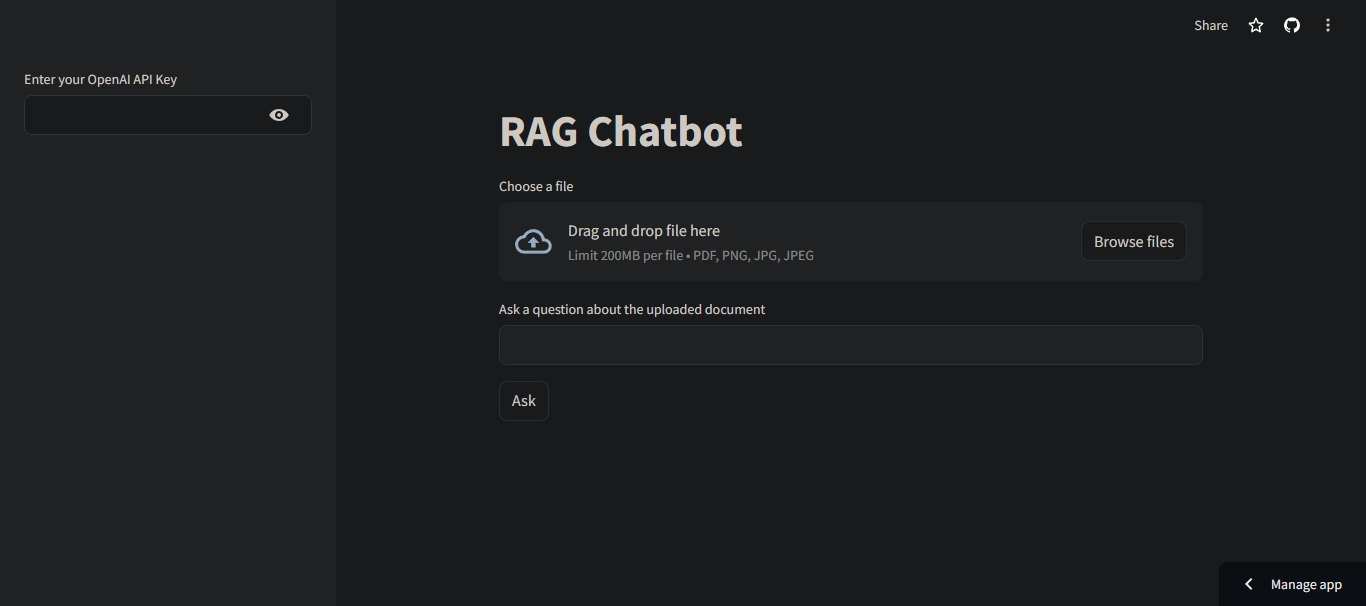

It is a clean, minimal interface with two input fields - one for the document, the other for asking questions about the document. In the left sidebar, the user is asked to input their API key. 

To build the interface, open the `app.py` script in the topmost level of your working directory and paste the following code:

```python
import streamlit as st
import os
from dotenv import load_dotenv
from src.document_processor import process_document
from src.rag_chain import create_rag_chain

# Load environment variables
load_dotenv()

st.set_page_config(page_title="RAG Chatbot", page_icon="🤖")

st.title("RAG Chatbot")

# Initialize session state
if "rag_chain" not in st.session_state:
    st.session_state.rag_chain = None

# Sidebar for API key input
with st.sidebar:
    api_key = st.text_input("Enter your OpenAI API Key", type="password")
    if api_key:
        os.environ["OPENAI_API_KEY"] = api_key

# File uploader
uploaded_file = st.file_uploader("Choose a file", type=["pdf", "png", "jpg", "jpeg"])

if uploaded_file is not None:
    if st.button("Process File"):
        if api_key:
            with st.spinner("Processing file..."):
                # Save the uploaded file temporarily
                with open(uploaded_file.name, "wb") as f:
                    f.write(uploaded_file.getbuffer())

                try:
                    # Process the document
                    chunks = process_document(uploaded_file.name)

                    # Create RAG chain
                    st.session_state.rag_chain = create_rag_chain(chunks)

                    st.success("File processed successfully!")
                except ValueError as e:
                    st.error(str(e))
                finally:
                    # Remove the temporary file
                    os.remove(uploaded_file.name)
        else:
            st.error("Please provide your OpenAI API key.")

# Query input
query = st.text_input("Ask a question about the uploaded document")

if st.button("Ask"):
    if st.session_state.rag_chain and query:
        with st.spinner("Generating answer..."):
            result = st.session_state.rag_chain.invoke(query)

            st.subheader("Answer:")
            st.write(result)
    elif not st.session_state.rag_chain:
        st.error("Please upload and process a file first.")
    else:
        st.error("Please enter a question.")
```

Despite being only 65 lines long, it implements the following functionality:

1. API key input: Allows users to enter their OpenAI API key securely.
2. File upload: Supports uploading PDF, PNG, JPG, and JPEG files.
3. Document processing: Processes the uploaded file and creates text chunks.
4. RAG chain creation: Builds a Retrieval-Augmented Generation chain using the processed document chunks.
5. Query handling: Accepts user questions about the uploaded document.
6. Answer generation: Uses the RAG chain to generate answers based on the uploaded document and user query.
7. Error handling: Provides appropriate error messages for missing API keys, unprocessed files, or empty queries.
8. User feedback: Displays spinners during processing and success/error messages to keep the user informed.
9. State management: Utilizes Streamlit's session state to maintain the RAG chain across interactions.

### 5. Deploying as a Streamlit chatbot

There is only one step left - deploying our Streamlit app. There are many options here but the easiest way is by using Streamlit Cloud, which is free and easy to set up.

First, open the `.streamlit/config.toml` script and past the following configurations:

```python
[theme]
primaryColor = "#F63366"
backgroundColor = "#FFFFFF"
secondaryBackgroundColor = "#F0F2F6"
textColor = "#262730"
font = "sans serif"
```

These are some theme adjustments that come from personal preferences. Then, write up the README.md file (you can copy its contents from [this hosted file on GitHub](https://github.com/BexTuychiev/rag_tutorial_hackernoon/blob/master/README.md)).

Finally, go to GitHub.com and create a new repository. Copy its link and return to your working directory:

```bash
$ git init
$ git add .
$ git commit -m "Initial commit"
$ git remote add origin https://github.com/YourUsername/YourRepo.git
$ git push --set-upstream origin master
```

The above commands initialize Git, create an initial commit and push everything to the repository (don't forget to replace the repo link with your own). 

Now, you have to sign up for a free account at [Streamlit Cloud](https://streamlit.io/cloud). Connect your GitHub account and select the repository containing your app. Then, configure the app settings:

- Set the Python version (e.g., 3.9)
- Set the main file path to app.py
- Add any necessary secrets (like OPENAI_API_KEY) in the app settings

Finally, click "Deploy"!

The app must be operational within minutes. The app I've built for this tutorial can be found at [this link](https://bex-rag-tutorial.streamlit.app/). Try it out!

![](images/rag_app.gif)

## Conclusion

This tutorial looks at the potent mix of Retrieval-Augmented Generation (RAG) and Streamlit that forms an interactive question-answering system based on documents. It takes the reader through the whole process, from setting up an environment and processing documents to building a RAG chain and deploying a friendly web app. 

Important points include: 
- RAG for a smarter (in the external knowledge sense) language model
- RAG chains can be built using LangChain, OpenAI's models, and third-party community integrations.
- The app can be made interactive using Streamlit and be deployed for public use.

This project forms the basis for applications that are more advanced. It can be extended in significant ways, such as the incorporation of multiple document types, improved retrieval accuracy, and features like document summarization. And yet, what it really serves is as a demonstration of the potential power of these technologies, individually and combined. 